In [1]:
import numpy as np
import wisps
import splat
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold,RepeatedKFold

import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
comb=pd.read_hdf(wisps.COMBINED_PHOTO_SPECTRO_FILE, key='new_stars')

In [3]:
comb=comb.iloc[(comb[wisps.INDEX_NAMES]).dropna().index]

In [4]:
comb=comb.dropna()

In [5]:
train_df=pd.read_pickle(wisps.LIBRARIES+'/training_set.pkl').reset_index(drop=True)
                                                                           
pred_df=wisps.Annotator.reformat_table(comb).reset_index(drop=True)

In [6]:
pred_df=pred_df.drop_duplicates(subset='grism_id')

In [7]:
pred_df.shape, train_df.shape

((70327, 26), (9728, 26))

In [8]:
def apply_scale(x):
    ##put features on a log scale
    #replace nans
    y=np.log10(x)
    if np.isnan(y) or np.isinf(y):
        y=np.random.uniform(-99, -98)
    return y

def create_labels(row):
    #use multiclass system
    label=0
    if row.label ==0.:
        label=0
    if (row.label==1) & (row.spt <20):
        label=1
    if (row.label==1) & np.logical_and(row.spt >=20, row.spt<30):
        label=2
    if (row.label==1) & np.logical_and(row.spt >=30, row.spt<45):
        label=3
    return label

In [9]:

pred_df['grism_id']=pred_df.grism_id.apply(lambda x: x.lower())

In [10]:
#features=wisps.INDEX_NAMES
features=np.concatenate([['snr2','snr1', 'snr3', 'snr4', 'f_test', 'line_chi', 'spex_chi'], wisps.INDEX_NAMES])
#features=['snr2','snr1', 'snr3', 'snr4', 'f_test']

In [11]:
pred_df=pred_df[pred_df.snr2>3.]
train_df['spt']=train_df.spt.apply(wisps.make_spt_number)
pred_df['spt']=pred_df.spt.apply(wisps.make_spt_number)

In [12]:
labels=train_df.apply(create_labels, axis=1).values

In [13]:
train_df[features]=(train_df[features]).applymap(apply_scale)
pred_df[features]=(pred_df[features]).applymap(apply_scale)

In [14]:
scaler = MinMaxScaler(feature_range=(-100, 100))
scaler.fit(train_df[features])
X=scaler.transform(train_df[features])
y=labels

In [15]:
#scale the data set to predict for the prediction set
pred_set=scaler.transform(pred_df[features])

In [16]:
class_weigths={0:1., 1:40/10000, 2:1/10000, 3:5/10000}

In [17]:


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.5,  random_state=np.random.randint(1000))
    
rf = RandomForestClassifier(n_estimators=10000, min_samples_split=2, verbose=True,bootstrap=True, n_jobs=-1, 
                            class_weight=class_weigths, criterion='entropy',  random_state=np.random.randint(1000), 
                            warm_start=False)
rf.fit(X_train, y_train)
pred_labels = rf.predict(X_test)
model_accuracy = accuracy_score(y_test, pred_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 10000 out of 

In [18]:
print ('accuracy score {}'.format(model_accuracy))
classes=['non-UCD', 'M7-L0', 'L', 'T']
cm = pd.DataFrame(confusion_matrix(y_test, pred_labels), 
                  columns=classes, index=classes)


accuracy score 0.9775904605263158


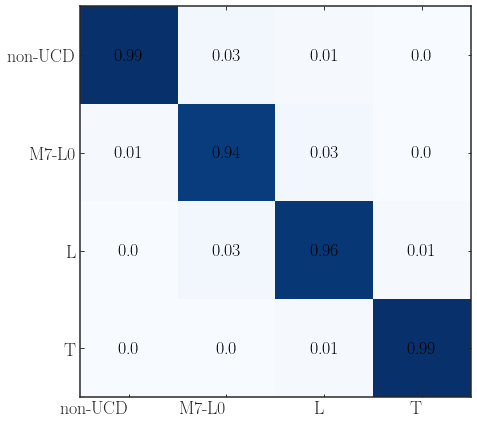

In [19]:
#create a table a confusion matrix

fig, ax=plt.subplots(figsize=(8, 6))

matr=(cm/cm.sum()).applymap(lambda x: np.round(x, 2)).values
im = ax.imshow(matr, cmap='Blues')

# We want to show all ticks...
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
# ... and label them with the respective list entries
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax.text(j, i, matr[i, j], ha="center", va="center", color="k", fontsize=18)
ax.set_xlim([-0.5, 3.5])
ax.set_ylim([3.5, -0.5])
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/confusion_matrix.pdf')

In [20]:



#cleanup
X_train.shape

(4864, 23)

In [21]:
'accuracy score {}'.format(model_accuracy)

'accuracy score 0.9775904605263158'

In [22]:
rlabels=rf.predict(pred_set)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:    9.3s
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:   12.0s
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed:   14.8s
[Parallel(n_jobs=4)]: Done 6042 tasks      | elapsed:   17.6s
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed:   20.1s
[Parallel(n_jobs=4)]: Done 8442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=4)]: Done 9792 tasks      | elapsed:   26.8s
[Parallel(n_jobs=4)]: Done 10000 out of 10000 | elapsed:

In [23]:
len(rlabels[rlabels>0])

119

In [24]:
cands=pd.read_pickle(wisps.OUTPUT_FILES+'/true_spectra_cands.pkl')

In [25]:
cands['grism_id']=cands.grism_id.apply(lambda x: x.lower())
cands['spt']=[x.spectral_type for x in cands.spectra]

In [26]:
len(cands), len( pred_df[pred_df.grism_id.isin(cands.grism_id.values)])

(364, 348)

In [27]:
strs=wisps.datasets['stars']

In [28]:
#cands[~ cands.grism_id.isin(pred_df.grism_id.values) ]

In [29]:
cands[~ cands.grism_id.isin(strs.grism_id.values) ]

,grism_id,spectra,spt


In [30]:
cands=cands[cands.spt>=17]

In [31]:
true=(pred_df[(rlabels>0) & pred_df.grism_id.isin(cands.grism_id.values)]).drop_duplicates(subset='grism_id')
truep=len(true)
ps=len(rlabels[rlabels>0])

In [32]:
len(true[true.spt.between(17,20)]), len(true[true.spt.between(20,30)]), len(true[true.spt.between(30,40)])

(30, 10, 5)

In [33]:
'FP rate {}'.format((ps-truep)/ps)

'FP rate 0.6386554621848739'

In [34]:
rf_dict={'classifier': rf,
            'sclr':scaler,
            'feats':features}

In [35]:
import pickle

In [36]:
#save the random forest
output_file=wisps.OUTPUT_FILES+'/random_forest_classifier.pkl'
with open(output_file, 'wb') as file:
    pickle.dump(rf_dict,file)

In [37]:
sv_df=pred_df[(rlabels>0)]

In [38]:
sv_df.to_pickle(wisps.LIBRARIES+'/labelled_by_rf.pkl')

In [39]:
slbyids=pd.read_pickle(wisps.OUTPUT_FILES+'/selected_by_indices.pkl')

In [40]:
#slbyids

In [41]:
len(sv_df[(sv_df.grism_id.isin(slbyids.grism_id)) & (sv_df.grism_id.isin(cands.grism_id))])

12

In [42]:
len(sv_df[( ~sv_df.grism_id.isin(slbyids.grism_id)) & (sv_df.grism_id.isin(cands.grism_id))])

31

In [43]:
len(slbyids[( ~slbyids.grism_id.isin(sv_df.grism_id)) & (slbyids.grism_id.isin(cands.grism_id))])

33